Fetching data for SPY


[*********************100%***********************]  1 of 1 completed


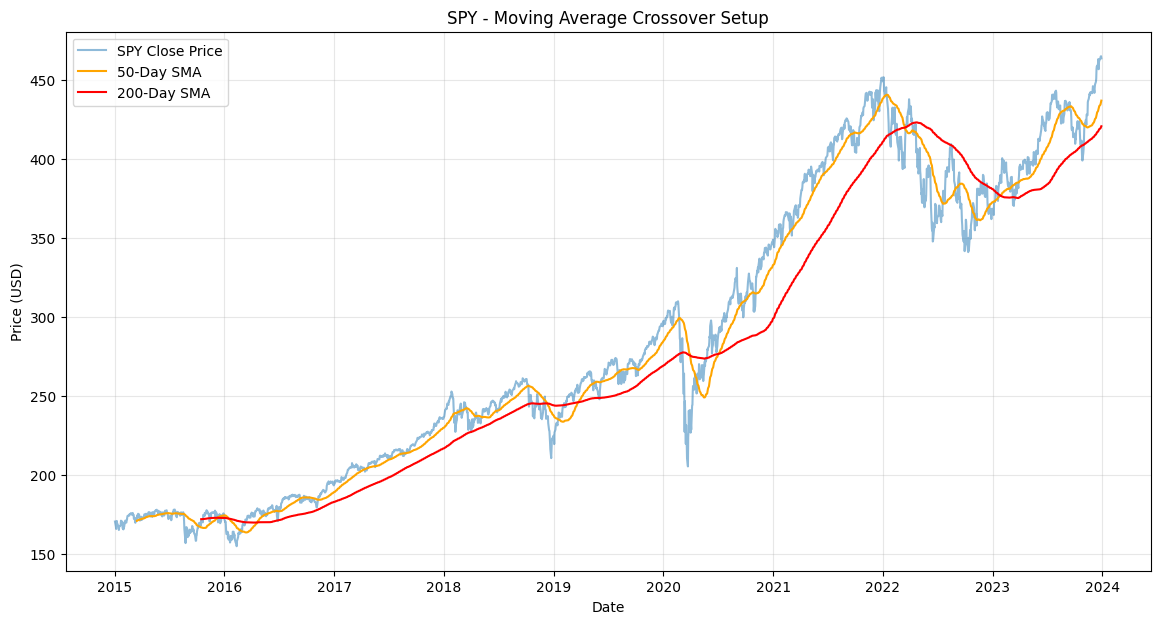

Price,Close,High,Low,Open,Volume,SMA_50,SMA_200
Ticker,SPY,SPY,SPY,SPY,SPY,,
Date,,,,,,,
2023-12-22,462.223358,463.911633,460.320419,462.428284,67160400,433.614597,419.025102
2023-12-26,464.175110,465.082667,462.555153,462.633240,55387000,434.510304,419.491168
2023-12-27,465.014374,465.160749,463.433460,463.970180,68000300,435.334543,419.964074
2023-12-28,465.189941,466.029180,464.770322,465.375360,77158100,436.162684,420.407241
2023-12-29,463.843292,465.521799,461.881773,464.994818,122283100,437.076830,420.855450


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf

ticker = 'SPY'
start_date = '2015-01-01'
end_date = '2023-12-31'

#getting data from yahoo finance
print(f"Fetching data for {ticker}")
data = yf.download(ticker, start=start_date, end=end_date)

#calculating 50-day and 200-day simple moving averages
data['SMA_50'] = data['Close'].rolling(window=50).mean()
data['SMA_200'] = data['Close'].rolling(window=200).mean()

#plotting the closing price and moving averages
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='SPY Close Price', alpha=0.5)
plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='orange')
plt.plot(data.index, data['SMA_200'], label='200-Day SMA', color='red')
plt.title(f'{ticker} - Moving Average Crossover Setup')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True , alpha=0.3)
plt.show()

data.tail()

In [2]:
#create signal column
# 1 = long/buy , 0 = short/sell

data['Signal'] =  np.where(data['SMA_50'] > data['SMA_200'], 1.0, 0.0)

#set position depending on the signal of current and previous day
# if 0 and 1 , diff=1 -> buy signal
# if 1 and 0 , diff=-1 -> sell signal
# if 1 and 1 or 0 and 0 , diff=0 -> hold signal

data['Position'] = data['Signal'].diff()

# view dates where an action was taken , buy or sell , position!=0
trades = data[data['Position']!=0.0].dropna()
trades[['Close', 'SMA_50', 'SMA_200', 'Signal', 'Position']].tail()

Price,Close,SMA_50,SMA_200,Signal,Position
Ticker,SPY,,,,
Date,,,,,
2019-03-26,253.934341,246.518521,246.191815,1.0,1.0
2020-03-31,237.581512,275.031232,275.718438,0.0,-1.0
2020-07-06,293.527405,277.458969,276.838187,1.0,1.0
2022-03-16,412.061401,419.435038,420.033369,0.0,-1.0
2023-01-26,389.072113,377.097853,376.971601,1.0,1.0


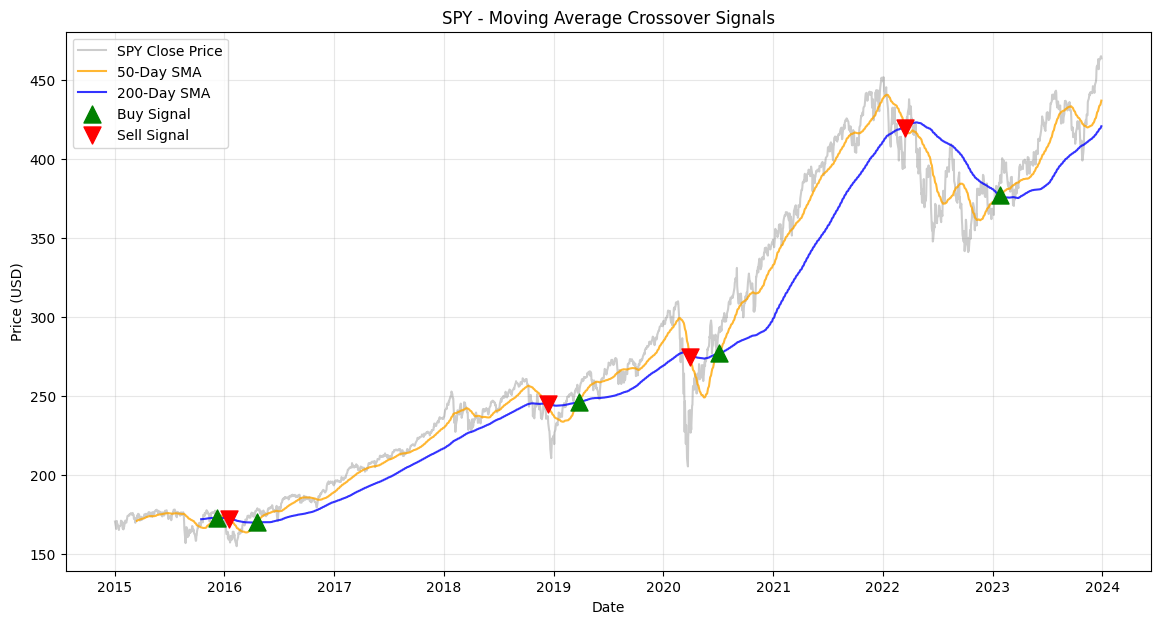

In [3]:
# isolate buy and sell signals
buy_signals = data[data['Position'] == 1.0]
sell_signals = data[data['Position'] == -1.0]

# plot buy and sell signals on the price chart
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='SPY Close Price', alpha=0.4, color='gray')
plt.plot(data.index, data['SMA_50'], label='50-Day SMA', color='orange', alpha=0.8)
plt.plot(data.index, data['SMA_200'], label='200-Day SMA', color='blue', alpha=0.8)

# mark ^ buy , v sell
plt.scatter(buy_signals.index, buy_signals['SMA_50'], marker='^', color='green', label='Buy Signal', s=150, zorder=5)
plt.scatter(sell_signals.index, sell_signals['SMA_50'], marker='v', color='red', label='Sell Signal', s=150, zorder=5)

#formatting the plot
plt.title(f'{ticker} - Moving Average Crossover Signals')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [4]:
# calculate number of buy and sell signals
signal_counts = data['Position'].value_counts()
print("Signal Counts:"+signal_counts.to_string())

Signal Counts:Position
 0.0    2254
 1.0       5
-1.0       4


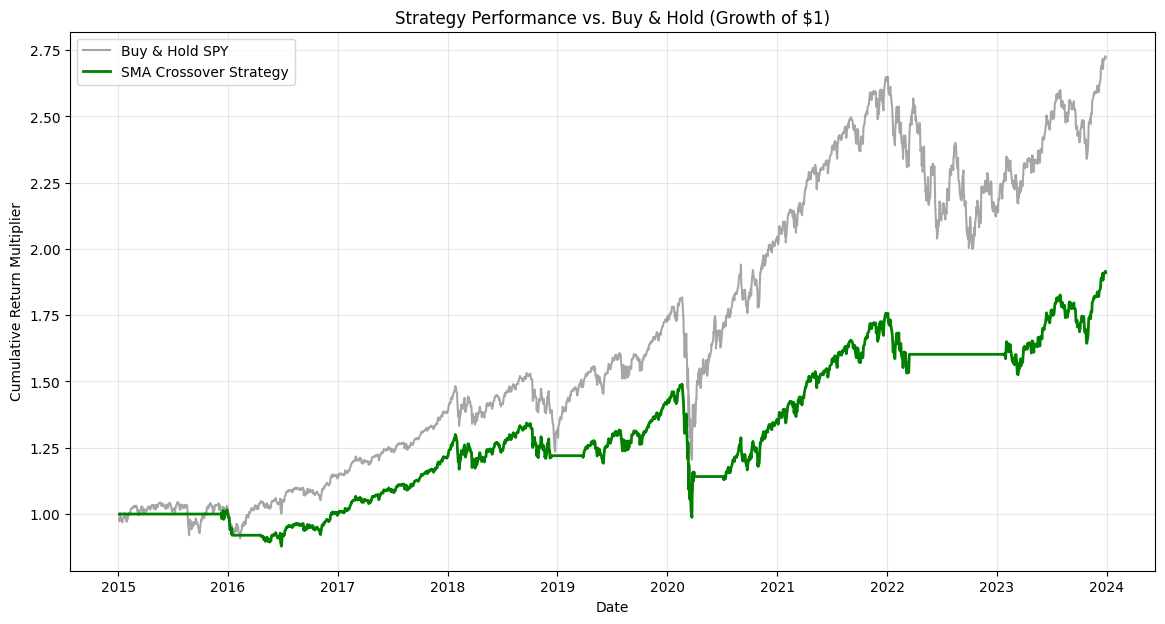

Buy & Hold Return: 171.91%
Strategy Return:   91.05%


In [5]:
# calculating returns

# calculate daily percentage return of holding SPY
data['Market_Returns'] = data['Close'].pct_change()

# calculate strategy returns
data['Strategy_Returns'] = data['Market_Returns'] * data['Signal'].shift(1)

# calculate cumulative returns
data['Cumulative_Market'] = (1 + data['Market_Returns']).cumprod()
data['Cumulative_Strategy'] = (1 + data['Strategy_Returns']).cumprod()

# plot equity curves

plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Cumulative_Market'], label='Buy & Hold SPY', color='gray', alpha=0.7)
plt.plot(data.index, data['Cumulative_Strategy'], label='SMA Crossover Strategy', color='green', linewidth=2)
plt.title('Strategy Performance vs. Buy & Hold (Growth of $1)')
plt.xlabel('Date')
plt.ylabel('Cumulative Return Multiplier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# print final returns

final_market = data['Cumulative_Market'].iloc[-1]
final_strategy = data['Cumulative_Strategy'].iloc[-1]
print(f"Buy & Hold Return: {(final_market - 1) * 100:.2f}%")
print(f"Strategy Return:   {(final_strategy - 1) * 100:.2f}%")


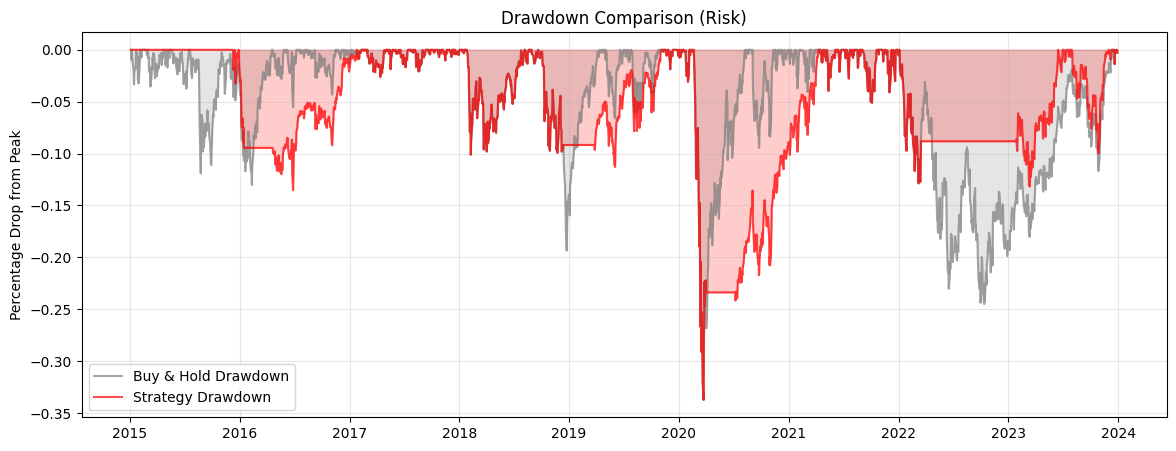

Buy & Hold Max Drawdown: -33.72%
Strategy Max Drawdown:   -33.72%


In [6]:
# calculating maximum drawdown

# calculate historical peaks for both market and strategy
data['Peak_Market'] = data['Cumulative_Market'].cummax()
data['Peak_Strategy'] = data['Cumulative_Strategy'].cummax()

# calculate daily drawdown
data['Drawdown_Market'] = (data['Cumulative_Market'] - data['Peak_Market']) / data['Peak_Market']
data['Drawdown_Strategy'] = (data['Cumulative_Strategy'] - data['Peak_Strategy']) / data['Peak_Strategy']

# calculate worst drop , minimum value
max_dd_market = data['Drawdown_Market'].min()
max_dd_strategy = data['Drawdown_Strategy'].min()

# plot the drawdown curves
plt.figure(figsize=(14, 5))
plt.plot(data.index, data['Drawdown_Market'], label='Buy & Hold Drawdown', color='gray', alpha=0.7)
plt.plot(data.index, data['Drawdown_Strategy'], label='Strategy Drawdown', color='red', alpha=0.7)
plt.fill_between(data.index, data['Drawdown_Market'], 0, color='gray', alpha=0.2)
plt.fill_between(data.index, data['Drawdown_Strategy'], 0, color='red', alpha=0.2)
plt.title('Drawdown Comparison (Risk)')
plt.ylabel('Percentage Drop from Peak')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# print maximum drawdown results
print(f"Buy & Hold Max Drawdown: {max_dd_market * 100:.2f}%")
print(f"Strategy Max Drawdown:   {max_dd_strategy * 100:.2f}%")